In [19]:
import argparse, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl import graph_index
from dgl.graph_index import disjoint_partition
from dgl.data import register_data_args, load_data
import math
from cacheout import Cache,LRUCache,MRUCache,LFUCache,FIFOCache,LIFOCache,RRCache

In [82]:
    parser = argparse.ArgumentParser(description='GCN')
    parser.add_argument("--dataset", type=str, default="Cora",
            help="dropout probability")
    parser.add_argument("--dropout", type=float, default=0.5,
            help="dropout probability")
    parser.add_argument("--gpu", type=int, default=-1,
            help="gpu")
    parser.add_argument("--lr", type=float, default=1e-2,
            help="learning rate")
    parser.add_argument("--n-epochs", type=int, default=200,
            help="number of training epochs")
    parser.add_argument("--n-hidden", type=int, default=16,
            help="number of hidden gcn units")
    parser.add_argument("--n-layers", type=int, default=1,
            help="number of hidden gcn layers")
    parser.add_argument("--weight-decay", type=float, default=5e-4,
            help="Weight for L2 loss")
    parser.add_argument("--self-loop", action='store_true',
            help="graph self-loop (default=False)")
    parser.set_defaults(self_loop=False)
    args = parser.parse_args(args=[])

In [119]:
data = load_data(args)
n_edges = data.graph.number_of_edges()
g = DGLGraph(data.graph)
degree = g.in_degrees()+g.out_degrees()
degree_sort = [i[0] for i in sorted(enumerate(degree), key=lambda x: x[1], reverse=True)]
degree_cache_value = [list() for _ in range(32)]
for val_ in degree_sort:
    degree_cache_value[val_%32].append(val_)

Finished data loading and preprocessing.
  NumNodes: 65755
  NumEdges: 251550
  NumFeats: 5414
  NumClasses: 210
  NumTrainingSamples: 105
  NumValidationSamples: 500
  NumTestSamples: 969


In [120]:
partition_size = 32
Node_index = []
Edge = []
Edge_number = []
partition_number = math.ceil(g.number_of_nodes() / partition_size)
print("the graph split to {:d} part". format(partition_number))
for node_id in range(partition_number):
    #print(node_id)
    if node_id == partition_number-1:
        index = list(range(partition_size*node_id,g.number_of_nodes()))
    else:
        index = list(range(partition_size*node_id,partition_size*(node_id+1)))
    Node_index.append(index)
    src, dst = g.out_edges(index)
    Edge.append(list(zip(src.tolist(),dst.tolist())))
    Edge_number.append(src.shape[0])

the graph split to 2055 part


In [100]:
Total_size = int(2048/32)
Precent = 0.1
Degree_size = int(Total_size*Precent)
Size = Total_size = Degree_size
Degree = Cache(Degree_size)
LRU = LRUCache(maxsize=Size)
MRU = MRUCache(maxsize=Size)
LFU = LFUCache(maxsize=Size)
FIFO = FIFOCache(maxsize=Size)
LIFO = LIFOCache(maxsize=Size)
RR   = RRCache(maxsize = Size)

In [95]:
cache_bank  = [Cache(maxsize=64) for _ in range(32)]
cache_hit = 0
cache_miss = 0
for e in Edge:
    for val_ in e:
        src, dst = val_
        if cache_bank[dst%32].has(dst):
            cache_hit = cache_hit + 1
        else:
            cache_bank[dst%32].set(dst, dst)
            cache_miss = cache_miss + 1
print('{}-{}-hit={}, miss={}'.format(pre, cache.__class__, cache_hit, cache_miss))

1.0-<class 'cacheout.lru.LRUCache'>-hit=136345, miss=115205


In [122]:
Total_size = 64
PrecentList = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for pre in PrecentList:
    Degree_size = int(Total_size*pre)
    Size = Total_size - Degree_size
    Degree = Cache(2048)
    print('{},{}'.format(Degree_size, Size))
    LRU = LRUCache(maxsize=Size)
    MRU = MRUCache(maxsize=Size)
    LFU = LFUCache(maxsize=Size)
    FIFO = FIFOCache(maxsize=Size)
    LIFO = LIFOCache(maxsize=Size)
    RR   = RRCache(maxsize = Size)
    #acheList = [LRU, MRU, LFU, FIFO, LIFO, RR]
    CacheList = [LRU]
    for cache in CacheList:
        cache_hit = 0
        cache_miss = 0
        cache_bank  = [cache for _ in range(32)]
        degree_bank = [Degree for _ in range(32)]
        if Degree_size:
            for i, val_ in enumerate(degree_cache_value):
                for id_ in val_[0:2048-1]:
                    #print('{},{}'.format(i,id_))
                    degree_bank[id_%32].set(id_, id_)
        for e in Edge:
            for val_ in e:
                src, dst = val_
                if degree_bank[dst%32].has(dst) or cache_bank[dst%32].has(dst):
                    cache_hit = cache_hit + 1
                else:
                    cache_bank[dst%32].set(dst, dst)
                    cache_miss = cache_miss + 1
        print('{}-{}-hit={}, miss={}'.format(pre, cache.__class__, cache_hit, cache_miss))

0,64
0-<class 'cacheout.lru.LRUCache'>-hit=95312, miss=156238
6,58
0.1-<class 'cacheout.lru.LRUCache'>-hit=98699, miss=152851
12,52
0.2-<class 'cacheout.lru.LRUCache'>-hit=96782, miss=154768
19,45
0.3-<class 'cacheout.lru.LRUCache'>-hit=94288, miss=157262
25,39
0.4-<class 'cacheout.lru.LRUCache'>-hit=91826, miss=159724
32,32
0.5-<class 'cacheout.lru.LRUCache'>-hit=88473, miss=163077
38,26
0.6-<class 'cacheout.lru.LRUCache'>-hit=85014, miss=166536
44,20
0.7-<class 'cacheout.lru.LRUCache'>-hit=80589, miss=170961
51,13
0.8-<class 'cacheout.lru.LRUCache'>-hit=73204, miss=178346
57,7
0.9-<class 'cacheout.lru.LRUCache'>-hit=61039, miss=190511
64,0
1.0-<class 'cacheout.lru.LRUCache'>-hit=187843, miss=63707


In [104]:
Total_size = 2048
PrecentList = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for pre in PrecentList:
    Degree_size = int(Total_size*pre)
    Size = Total_size - Degree_size
    Degree = Cache(Degree_size)
    LRU = LRUCache(maxsize=Size)
    MRU = MRUCache(maxsize=Size)
    LFU = LFUCache(maxsize=Size)
    FIFO = FIFOCache(maxsize=Size)
    LIFO = LIFOCache(maxsize=Size)
    RR   = RRCache(maxsize = Size)
    #CacheList = [LRU, MRU, LFU, FIFO, LIFO, RR]
    CacheList = [LRU]
    for cache in CacheList:
        cache_hit = 0
        cache_miss = 0
        if Degree_size:
            for id_ in degree_sort[0:Degree_size-1]:
                Degree.set(id_, id_)
        for e in Edge:
            for val_ in e:
                src, dst = val_
                if Degree.has(dst) or cache.has(dst):
                    cache_hit = cache_hit + 1
                else:
                    cache.set(dst, dst)
                    cache_miss = cache_miss + 1
        print('{}-{}-hit={}, miss={}'.format(pre, cache.__class__, cache_hit, cache_miss))

0-<class 'cacheout.lru.LRUCache'>-hit=138438, miss=113112
0.1-<class 'cacheout.lru.LRUCache'>-hit=139568, miss=111982
0.2-<class 'cacheout.lru.LRUCache'>-hit=140566, miss=110984
0.3-<class 'cacheout.lru.LRUCache'>-hit=141900, miss=109650
0.4-<class 'cacheout.lru.LRUCache'>-hit=143109, miss=108441
0.5-<class 'cacheout.lru.LRUCache'>-hit=143996, miss=107554
0.6-<class 'cacheout.lru.LRUCache'>-hit=144778, miss=106772
0.7-<class 'cacheout.lru.LRUCache'>-hit=145109, miss=106441
0.8-<class 'cacheout.lru.LRUCache'>-hit=144898, miss=106652
0.9-<class 'cacheout.lru.LRUCache'>-hit=143025, miss=108525
1.0-<class 'cacheout.lru.LRUCache'>-hit=187842, miss=63708


In [96]:
PrecentList = [0.5]
for pre in PrecentList:
    Degree_size = int(Total_size*pre)
    Size = Total_size - Degree_size
    Degree = Cache(Degree_size)
    LRU = LRUCache(maxsize=Size)
    MRU = MRUCache(maxsize=Size)
    LFU = LFUCache(maxsize=Size)
    FIFO = FIFOCache(maxsize=Size)
    LIFO = LIFOCache(maxsize=Size)
    RR   = RRCache(maxsize = Size)
    CacheList = [LRU, MRU, LFU, FIFO, LIFO, RR]
    #CacheList = [LRU]
    for cache in CacheList:
        cache_hit = 0
        cache_miss = 0
        if Degree_size:
            for id_ in degree_sort[0:Degree_size-1]:
                Degree.set(id_, id_)
        for e in Edge:
            for val_ in e:
                src, dst = val_
                if Degree.has(dst) or cache.has(dst):
                    cache_hit = cache_hit + 1
                else:
                    cache.set(dst, dst)
                    cache_miss = cache_miss + 1
        print('{}-{}-hit={}, miss={}'.format(pre, cache.__class__, cache_hit, cache_miss))

0.5-<class 'cacheout.lru.LRUCache'>-hit=115262, miss=136288
0.5-<class 'cacheout.mru.MRUCache'>-hit=96109, miss=155441
0.5-<class 'cacheout.lfu.LFUCache'>-hit=104798, miss=146752
0.5-<class 'cacheout.fifo.FIFOCache'>-hit=114575, miss=136975
0.5-<class 'cacheout.lifo.LIFOCache'>-hit=101205, miss=150345
0.5-<class 'cacheout.rr.RRCache'>-hit=113931, miss=137619


In [128]:
Total_size = [32,64,128,256,512,1024,2048,4096,8192,16384]
PrecentList = [1]
Hit = []
for pre in Total_size:
    Degree = Cache(pre)
    LRU = LRUCache(maxsize=Size)
    MRU = MRUCache(maxsize=Size)
    LFU = LFUCache(maxsize=Size)
    FIFO = FIFOCache(maxsize=Size)
    LIFO = LIFOCache(maxsize=Size)
    RR   = RRCache(maxsize = Size)
    #CacheList = [LRU, MRU, LFU, FIFO, LIFO, RR]
    CacheList = [LRU]
    for cache in CacheList:
        cache_hit = 0
        cache_miss = 0
        if Degree_size:
            for id_ in degree_sort[0:pre-1]:
                Degree.set(id_, id_)
        for e in Edge:
            for val_ in e:
                src, dst = val_
                if Degree.has(dst):
                    cache_hit = cache_hit + 1
                else:
                    cache_miss = cache_miss + 1
        Hit.append(cache_hit)
        print('{}-{}-hit={}, miss={}'.format(pre, cache.__class__, cache_hit, cache_miss))

32-<class 'cacheout.lru.LRUCache'>-hit=47745, miss=203805
64-<class 'cacheout.lru.LRUCache'>-hit=69022, miss=182528
128-<class 'cacheout.lru.LRUCache'>-hit=92110, miss=159440
256-<class 'cacheout.lru.LRUCache'>-hit=112547, miss=139003
512-<class 'cacheout.lru.LRUCache'>-hit=123692, miss=127858
1024-<class 'cacheout.lru.LRUCache'>-hit=131968, miss=119582
2048-<class 'cacheout.lru.LRUCache'>-hit=141692, miss=109858
4096-<class 'cacheout.lru.LRUCache'>-hit=154043, miss=97507
8192-<class 'cacheout.lru.LRUCache'>-hit=170417, miss=81133
16384-<class 'cacheout.lru.LRUCache'>-hit=191357, miss=60193


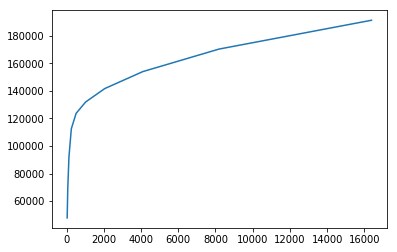

In [129]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(Total_size,Hit)
plt.show()